In [32]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

# 1. Remove specified columns
columns_to_remove = ['nplay_video', 'incomplete_flag', 'roles']
df_cleaned = df.drop(columns=columns_to_remove)

# 2. Handle missing values
# For categorical variables (LoE_DI) - impute with mode
df_cleaned['LoE_DI'] = df_cleaned['LoE_DI'].fillna(df_cleaned['LoE_DI'].mode()[0])

# For gender in random way
missing_indices = df_cleaned[df_cleaned['gender'].isnull()].index
df_cleaned.loc[missing_indices, 'gender'] = np.random.choice(df_cleaned['gender'].dropna(), len(missing_indices))

# For YoB - impute with median
df_cleaned['YoB'] = df_cleaned['YoB'].fillna(df_cleaned['YoB'].median())

# 3. Drop rows with missing grades
df_cleaned = df_cleaned.dropna(subset=['grade'])

# 5. Define function for nchapters imputation
def impute_nchapters_simple(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and some activity (ndays_act <= 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3),
        # Condition 4: No activity recorded (ndays_act is NaN) but viewed course
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 1),
        # Condition 5: No activity and never viewed (complete non-engagement)
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 0)
    ]
    
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified active students
        1,   # Minimal engagement
        1,   # Viewed but no sustained activity
        0    # Never engaged with content
    ]
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# Apply nchapters imputation
df_cleaned['nchapters_imputed'] = impute_nchapters_simple(df_cleaned)

# 6. nevents missing data
def impute_nevents(row):
    if pd.isna(row['nevents']):  # Only impute if the value is missing
        if row['nchapters'] == 0:
            return 0
        elif row['nchapters'] == 1:
            return np.random.choice([0, 1], p=[0.7, 0.3])
        elif 2 <= row['nchapters'] <= 5:
            return np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
        elif 6 <= row['nchapters'] <= 12:
            return np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        else:
            return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:
        return row['nevents']  # Return original value if not missing

# Set random seed for reproducibility
np.random.seed(42)

# Create new column with imputed values
df_cleaned['nevents_imputed'] = df_cleaned.apply(impute_nevents, axis=1)

# 7. Save the cleaned dataset with all changes
df_cleaned.to_csv('cleaned_dataset.csv', index=False)


In [101]:
pip install tensorflow


     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.4/390.3 MB 8.9 MB/s eta 0:00:44
   ---------------------------------------- 1.1/390.3 MB 13.4 MB/s eta 0:00:30
   ---------------------------------------- 1.7/390.3 MB 12.0 MB/s eta 0:00:33
   ---------------------------------------- 2.3/390.3 MB 12.4 MB/s eta 0:00:32
   ---------------------------------------- 3.0/390.3 MB 12.6 MB/s eta 0:00:31
   ---------------------------------------- 3.6/390.3 MB 12.7 MB/s eta 0:00:31
   ---------------------------------------- 4.2/390.3 MB 13.4 MB/s eta 0:00:29
   ---------------------------------------- 4.8/390.3 MB 12.9 MB/s eta 0:00:30
    --------------------------------------- 5.5/390.3 MB 12.9 MB/s eta 0:00:30
    --------------------------------------- 6.1/390.3 MB 13.0 MB/s

In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

class EfficientNCF:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.model = None
        
    def preprocess_data(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Preprocess the data efficiently
        """
        print("Starting preprocessing...")
        
        # Encode users and items
        df['user_idx'] = self.user_encoder.fit_transform(df[user_col])
        df['item_idx'] = self.item_encoder.fit_transform(df[item_col])
        
        # Get dimensions
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        
        print(f"Number of users: {self.n_users}, Number of items: {self.n_items}")
        return df

    def generate_negative_samples(self, df, neg_ratio=1):
        """
        Generate negative samples more efficiently
        """
        print("Generating negative samples...")
        
        # Create positive samples dataframe
        pos_samples = df[['user_idx', 'item_idx']].copy()
        pos_samples['label'] = 1
        
        # Create set of positive interactions for faster lookup
        pos_interactions = set(zip(df['user_idx'], df['item_idx']))
        
        # Generate negative samples
        neg_samples = []
        for user in df['user_idx'].unique():
            n_neg = min(int(df[df['user_idx'] == user].shape[0] * neg_ratio), 10)
            neg_items = np.random.randint(0, self.n_items, size=n_neg * 2)
            valid_negs = [(user, item) for item in neg_items 
                         if (user, item) not in pos_interactions][:n_neg]
            neg_samples.extend(valid_negs)
        
        # Convert negative samples to dataframe
        neg_df = pd.DataFrame(neg_samples, columns=['user_idx', 'item_idx'])
        neg_df['label'] = 0
        
        # Combine positive and negative samples
        final_df = pd.concat([pos_samples, neg_df], ignore_index=True)
        print(f"Final dataset shape: {final_df.shape}")
        
        return final_df

    def build_model(self, embedding_dim=32):
        """
        Build a simplified NCF model
        """
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')
        
        # Embedding layers
        user_embedding = Embedding(self.n_users, embedding_dim, name='user_embedding')(user_input)
        item_embedding = Embedding(self.n_items, embedding_dim, name='item_embedding')(item_input)
        
        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        
        # Concatenate embeddings
        concat = Concatenate()([user_flat, item_flat])
        
        # Dense layers
        dense1 = Dense(64, activation='relu')(concat)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(1, activation='sigmoid')(dense2)
        
        model = Model(inputs=[user_input, item_input], outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        return model

    def train(self, train_data, validation_split=0.2, batch_size=2048, epochs=10):
        """
        Train the model with early stopping
        """
        # Prepare training data
        X = train_data[['user_idx', 'item_idx']].values
        y = train_data['label'].values
        
        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
        
        # Train model
        history = self.model.fit(
            [X_train[:, 0], X_train[:, 1]], 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        
        return history

    def get_recommendations(self, user_id, top_n=5):
        """
        Get recommendations for a specific user
        """
        if user_id not in self.user_encoder.classes_:
            return []
        
        user_idx = self.user_encoder.transform([user_id])[0]
        
        # Create user-item pairs for prediction
        items = np.arange(self.n_items)
        user_items = np.array([[user_idx, item_idx] for item_idx in items])
        
        # Get predictions
        predictions = self.model.predict(
            [user_items[:, 0], user_items[:, 1]], 
            batch_size=2048,
            verbose=0
        )
        
        # Get top N items
        top_item_indices = np.argsort(predictions.flatten())[-top_n:][::-1]
        recommended_items = self.item_encoder.inverse_transform(top_item_indices)
        
        return list(zip(recommended_items, predictions[top_item_indices].flatten()))

# Example usage
def main():
    # Sample usage code
    # Load your data
    df = pd.read_csv('cleaned_dataset.csv')
    
    # Initialize and train the model
    recommender = EfficientNCF()
    
    # Preprocess data
    processed_df = recommender.preprocess_data(df)
    
    # Generate training data with negative samples
    training_data = recommender.generate_negative_samples(processed_df, neg_ratio=1)
    
    # Build and train model
    recommender.build_model(embedding_dim=32)
    
    # Train model
    history = recommender.train(
        training_data,
        batch_size=2048,
        epochs=10
    )
    
    # Get recommendations for a user
    user_id = df['userid_DI'].iloc[0]  # Example user
    recommendations = recommender.get_recommendations(user_id, top_n=5)
    print("\nRecommendations:", recommendations)

if __name__ == "__main__":
    main()


Starting preprocessing...
Number of users: 447584, Number of items: 16
Generating negative samples...
Final dataset shape: (1181292, 3)
Epoch 1/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.6714 - loss: 0.6010 - val_accuracy: 0.6779 - val_loss: 0.5826
Epoch 2/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 54s 116ms/step - accuracy: 0.7440 - loss: 0.5008 - val_accuracy: 0.6784 - val_loss: 0.6007
Epoch 3/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 53s 114ms/step - accuracy: 0.9091 - loss: 0.2244 - val_accuracy: 0.6787 - val_loss: 0.7507

Recommendations: [('HarvardX/CS50x/2012', 0.8521104), ('MITx/6.00x/2012_Fall', 0.62702733), ('MITx/6.00x/2013_Spring', 0.54378307), ('HarvardX/ER22x/2013_Spring', 0.5138786), ('MITx/6.002x/2012_Fall', 0.43203673)]


In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

class ImprovedNCF:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.model = None
        
    def preprocess_data(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Preprocess the data efficiently
        """
        print("Starting preprocessing...")
        
        # Encode users and items
        df['user_idx'] = self.user_encoder.fit_transform(df[user_col])
        df['item_idx'] = self.item_encoder.fit_transform(df[item_col])
        
        # Get dimensions
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        
        print(f"Number of users: {self.n_users}, Number of items: {self.n_items}")
        return df

    def generate_negative_samples(self, df, neg_ratio=0.5):  # Reduced negative ratio
        """
        Generate negative samples more efficiently
        """
        print("Generating negative samples...")
        
        # Create positive samples dataframe
        pos_samples = df[['user_idx', 'item_idx']].copy()
        pos_samples['label'] = 1
        
        # Create set of positive interactions for faster lookup
        pos_interactions = set(zip(df['user_idx'], df['item_idx']))
        
        # Generate negative samples
        neg_samples = []
        for user in df['user_idx'].unique():
            n_neg = min(int(df[df['user_idx'] == user].shape[0] * neg_ratio), 5)  # Reduced max negatives
            neg_items = np.random.randint(0, self.n_items, size=n_neg * 2)
            valid_negs = [(user, item) for item in neg_items 
                         if (user, item) not in pos_interactions][:n_neg]
            neg_samples.extend(valid_negs)
        
        # Convert negative samples to dataframe
        neg_df = pd.DataFrame(neg_samples, columns=['user_idx', 'item_idx'])
        neg_df['label'] = 0
        
        # Combine positive and negative samples
        final_df = pd.concat([pos_samples, neg_df], ignore_index=True)
        print(f"Final dataset shape: {final_df.shape}")
        
        return final_df

    def build_model(self, embedding_dim=32):
        """
        Build improved NCF model with regularization
        """
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')
        
        # Embedding layers with regularization
        user_embedding = Embedding(
            self.n_users, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='user_embedding'
        )(user_input)
        
        item_embedding = Embedding(
            self.n_items, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='item_embedding'
        )(item_input)
        
        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        
        # Concatenate embeddings
        concat = Concatenate()([user_flat, item_flat])
        
        # Dense layers with dropout and regularization
        dense1 = Dense(64, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(concat)
        dropout1 = Dropout(0.2)(dense1)
        
        dense2 = Dense(32, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        
        output = Dense(1, activation='sigmoid')(dropout2)
        
        model = Model(inputs=[user_input, item_input], outputs=output)
        
        # Use a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        return model

    def train(self, train_data, validation_split=0.2, batch_size=2048, epochs=10):
        """
        Train the model with improved callbacks
        """
        # Prepare training data
        X = train_data[['user_idx', 'item_idx']].values
        y = train_data['label'].values
        
        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        # Modified early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            min_delta=0.001
        )
        
        # Add learning rate reduction
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.0001
        )
        
        # Train model
        history = self.model.fit(
            [X_train[:, 0], X_train[:, 1]], 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

    def get_recommendations(self, user_id, top_n=5):
        """
        Get recommendations for a specific user
        """
        if user_id not in self.user_encoder.classes_:
            return "User not found in training data"
        
        user_idx = self.user_encoder.transform([user_id])[0]
        
        # Create test data for all items
        test_user = np.array([user_idx] * self.n_items)
        test_items = np.array(range(self.n_items))
        
        # Get predictions
        predictions = self.model.predict([test_user, test_items], verbose=0)
        
        # Get top N recommendations
        top_indices = predictions.flatten().argsort()[-top_n:][::-1]
        
        # Convert back to original item IDs and include scores
        recommendations = [
            (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
            for idx in top_indices
        ]
        
        return recommendations

# Test the improved version
def test_improved_model(df):
    # Initialize the improved model
    improved_recommender = ImprovedNCF()
    
    # Preprocess data
    processed_df = improved_recommender.preprocess_data(df)
    
    # Generate training data with reduced negative samples
    training_data = improved_recommender.generate_negative_samples(processed_df)
    
    # Build and train the model
    improved_recommender.build_model()
    history = improved_recommender.train(training_data)
    
    # Get recommendations for a sample user
    sample_user = df['userid_DI'].iloc[0]
    recommendations = improved_recommender.get_recommendations(sample_user)
    
    print("\nSample recommendations for user:", sample_user)
    for course, score in recommendations:
        print(f"Course: {course}, Score: {score:.4f}")
    
    return improved_recommender, history

# Run the test
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('cleaned_dataset.csv')  # Replace with your data path
    
    # Test the improved model
    improved_model, history = test_improved_model(df)


Starting preprocessing...
Number of users: 447584, Number of items: 16
Generating negative samples...
Final dataset shape: (701014, 3)
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - accuracy: 0.8194 - loss: 37.2946 - val_accuracy: 0.8451 - val_loss: 0.5725 - learning_rate: 5.0000e-04
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - accuracy: 0.8468 - loss: 0.5183 - val_accuracy: 0.8451 - val_loss: 0.4296 - learning_rate: 5.0000e-04
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - accuracy: 0.8462 - loss: 0.4265 - val_accuracy: 0.8451 - val_loss: 0.4125 - learning_rate: 5.0000e-04
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 191ms/step - accuracy: 0.8461 - loss: 0.4147 - val_accuracy: 0.8451 - val_loss: 0.4081 - learning_rate: 5.0000e-04
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 179ms/step - accuracy: 0.8465 - loss: 0.4099 - val_accuracy: 0.8451 - val_loss: 0.4055 - learning_rate: 5.0000e-04
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 77s 160ms/step - accuracy: 0.

Starting preprocessing...
Number of users: 447584, Number of items: 16
Generating negative samples...
Final dataset shape: (701019, 3)
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.8430 - loss: 42.7820 - val_accuracy: 0.8463 - val_loss: 0.6428 - learning_rate: 5.0000e-04
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.8456 - loss: 0.5765 - val_accuracy: 0.8463 - val_loss: 0.4501 - learning_rate: 5.0000e-04
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.8451 - loss: 0.4422 - val_accuracy: 0.8463 - val_loss: 0.4158 - learning_rate: 5.0000e-04
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.8452 - loss: 0.4184 - val_accuracy: 0.8463 - val_loss: 0.4093 - learning_rate: 5.0000e-04
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.8468 - loss: 0.4101 - val_accuracy: 0.8463 - val_loss: 0.4066 - learning_rate: 5.0000e-04
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.

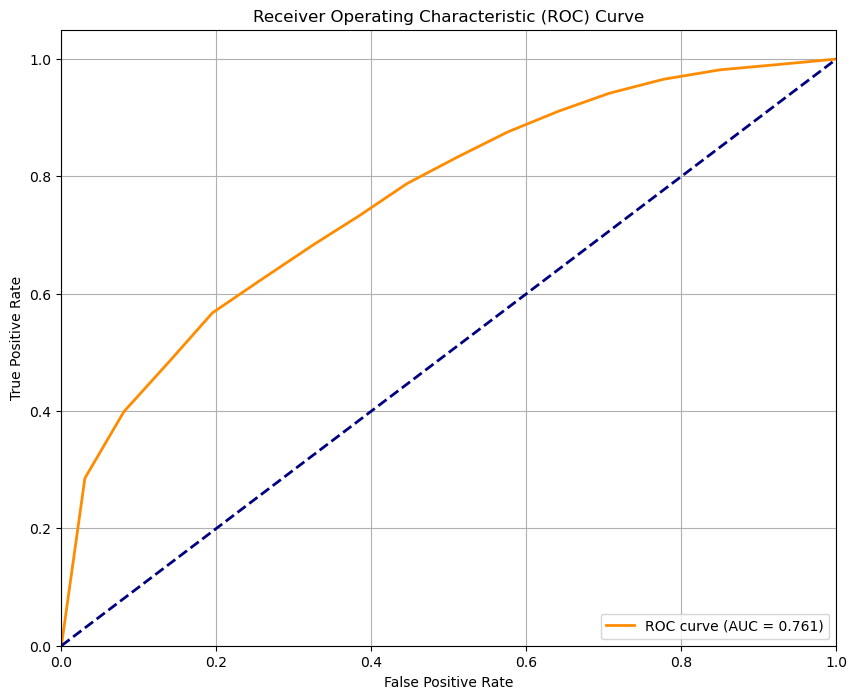

AUC Score: 0.7609

Sample recommendations for user: MHxPC130442623
Course: HarvardX/CS50x/2012, Score: 0.9654
Course: MITx/6.00x/2012_Fall, Score: 0.9020
Course: MITx/6.00x/2013_Spring, Score: 0.8761
Course: HarvardX/ER22x/2013_Spring, Score: 0.8714
Course: HarvardX/PH207x/2012_Fall, Score: 0.8248


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18876\4019370041.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18876\4019370041.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18876\4019370041.py:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depreca

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ImprovedNCF:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.model = None
        
    def preprocess_data(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Preprocess the data efficiently
        """
        print("Starting preprocessing...")
        
        # Encode users and items
        df['user_idx'] = self.user_encoder.fit_transform(df[user_col])
        df['item_idx'] = self.item_encoder.fit_transform(df[item_col])
        
        # Get dimensions
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        
        print(f"Number of users: {self.n_users}, Number of items: {self.n_items}")
        return df

    def generate_negative_samples(self, df, neg_ratio=0.5):  # Reduced negative ratio
        """
        Generate negative samples more efficiently
        """
        print("Generating negative samples...")
        
        # Create positive samples dataframe
        pos_samples = df[['user_idx', 'item_idx']].copy()
        pos_samples['label'] = 1
        
        # Create set of positive interactions for faster lookup
        pos_interactions = set(zip(df['user_idx'], df['item_idx']))
        
        # Generate negative samples
        neg_samples = []
        for user in df['user_idx'].unique():
            n_neg = min(int(df[df['user_idx'] == user].shape[0] * neg_ratio), 5)  # Reduced max negatives
            neg_items = np.random.randint(0, self.n_items, size=n_neg * 2)
            valid_negs = [(user, item) for item in neg_items 
                         if (user, item) not in pos_interactions][:n_neg]
            neg_samples.extend(valid_negs)
        
        # Convert negative samples to dataframe
        neg_df = pd.DataFrame(neg_samples, columns=['user_idx', 'item_idx'])
        neg_df['label'] = 0
        
        # Combine positive and negative samples
        final_df = pd.concat([pos_samples, neg_df], ignore_index=True)
        print(f"Final dataset shape: {final_df.shape}")
        
        return final_df

    def build_model(self, embedding_dim=32):
        """
        Build improved NCF model with regularization
        """
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')
        
        # Embedding layers with regularization
        user_embedding = Embedding(
            self.n_users, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='user_embedding'
        )(user_input)
        
        item_embedding = Embedding(
            self.n_items, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='item_embedding'
        )(item_input)
        
        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        
        # Concatenate embeddings
        concat = Concatenate()([user_flat, item_flat])
        
        # Dense layers with dropout and regularization
        dense1 = Dense(64, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(concat)
        dropout1 = Dropout(0.2)(dense1)
        
        dense2 = Dense(32, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        
        output = Dense(1, activation='sigmoid')(dropout2)
        
        model = Model(inputs=[user_input, item_input], outputs=output)
        
        # Use a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        return model

    def train(self, train_data, validation_split=0.2, batch_size=2048, epochs=10):
        """
        Train the model with improved callbacks
        """
        # Prepare training data
        X = train_data[['user_idx', 'item_idx']].values
        y = train_data['label'].values
        
        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        # Modified early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            min_delta=0.001
        )
        
        # Add learning rate reduction
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.0001
        )
        
        # Train model
        history = self.model.fit(
            [X_train[:, 0], X_train[:, 1]], 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

    def plot_roc_curve(self, test_data):
        """
        Calculate and plot ROC curve for the model
        """
        print("\nCalculating ROC curve...")
        
        # Get predictions for test data
        X_test = test_data[['user_idx', 'item_idx']].values
        y_true = test_data['label'].values
        
        # Get prediction scores
        y_scores = self.model.predict(
            [X_test[:, 0], X_test[:, 1]], 
            batch_size=2048,
            verbose=0
        ).flatten()
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        return roc_auc

    def get_recommendations(self, user_id, top_n=5):
        """
        Get recommendations for a specific user
        """
        if user_id not in self.user_encoder.classes_:
            return "User not found in training data"
        
        user_idx = self.user_encoder.transform([user_id])[0]
        
        # Create test data for all items
        test_user = np.array([user_idx] * self.n_items)
        test_items = np.array(range(self.n_items))
        
        # Get predictions
        predictions = self.model.predict([test_user, test_items], verbose=0)
        
        # Get top N recommendations
        top_indices = predictions.flatten().argsort()[-top_n:][::-1]
        
        # Convert back to original item IDs and include scores
        recommendations = [
            (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
            for idx in top_indices
        ]
        
        return recommendations

def test_improved_model(df):
    # Initialize the improved model
    improved_recommender = ImprovedNCF()
    
    # Preprocess data
    processed_df = improved_recommender.preprocess_data(df)
    
    # Generate training data with reduced negative samples
    full_data = improved_recommender.generate_negative_samples(processed_df)
    
    # Split into train and test sets
    train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)
    
    # Build and train the model
    improved_recommender.build_model()
    history = improved_recommender.train(train_data)
    
    # Calculate and plot ROC curve
    print("\nGenerating ROC curve...")
    auc_score = improved_recommender.plot_roc_curve(test_data)
    print(f"AUC Score: {auc_score:.4f}")
    
    # Get recommendations for a sample user
    sample_user = df['userid_DI'].iloc[0]
    recommendations = improved_recommender.get_recommendations(sample_user)
    
    print("\nSample recommendations for user:", sample_user)
    for course, score in recommendations:
        print(f"Course: {course}, Score: {score:.4f}")
    
    return improved_recommender, history, auc_score

# Run the test
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('cleaned_dataset.csv')  # Replace with your data path
    
    # Test the improved model
    improved_model, history, auc_score = test_improved_model(df)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

class ImprovedNCF:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.model = None
        self.n_users = None
        self.n_items = None
        
    def fit_encoders(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Fit the label encoders on training data
        """
        print("Fitting encoders...")
        self.user_encoder.fit(df[user_col])
        self.item_encoder.fit(df[item_col])
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        print(f"Number of users: {self.n_users}, Number of items: {self.n_items}")

    def preprocess_data(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Transform the data using fitted encoders
        """
        df['user_idx'] = self.user_encoder.transform(df[user_col])
        df['item_idx'] = self.item_encoder.transform(df[item_col])
        return df

    def generate_negative_samples(self, df, neg_ratio=0.5):  # Reduced negative ratio
        """
        Generate negative samples more efficiently
        """
        print("Generating negative samples...")
        
        # Create positive samples dataframe
        pos_samples = df[['user_idx', 'item_idx']].copy()
        pos_samples['label'] = 1
        
        # Create set of positive interactions for faster lookup
        pos_interactions = set(zip(df['user_idx'], df['item_idx']))
        
        # Generate negative samples
        neg_samples = []
        for user in df['user_idx'].unique():
            n_neg = min(int(df[df['user_idx'] == user].shape[0] * neg_ratio), 5)  # Reduced max negatives
            neg_items = np.random.randint(0, self.n_items, size=n_neg * 2)
            valid_negs = [(user, item) for item in neg_items 
                         if (user, item) not in pos_interactions][:n_neg]
            neg_samples.extend(valid_negs)
        
        # Convert negative samples to dataframe
        neg_df = pd.DataFrame(neg_samples, columns=['user_idx', 'item_idx'])
        neg_df['label'] = 0
        
        # Combine positive and negative samples
        final_df = pd.concat([pos_samples, neg_df], ignore_index=True)
        print(f"Final dataset shape: {final_df.shape}")
        
        return final_df

    def build_model(self, embedding_dim=32):
        """
        Build improved NCF model with regularization
        """
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')
        
        # Embedding layers with regularization
        user_embedding = Embedding(
            self.n_users, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='user_embedding'
        )(user_input)
        
        item_embedding = Embedding(
            self.n_items, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='item_embedding'
        )(item_input)
        
        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        
        # Concatenate embeddings
        concat = Concatenate()([user_flat, item_flat])
        
        # Dense layers with dropout and regularization
        dense1 = Dense(64, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(concat)
        dropout1 = Dropout(0.2)(dense1)
        
        dense2 = Dense(32, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        
        output = Dense(1, activation='sigmoid')(dropout2)
        
        model = Model(inputs=[user_input, item_input], outputs=output)
        
        # Use a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        return model

    def train(self, train_data, validation_split=0.2, batch_size=2048, epochs=10):
        """
        Train the model with improved callbacks
        """
        # Prepare training data
        X = train_data[['user_idx', 'item_idx']].values
        y = train_data['label'].values
        
        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        # Modified early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            min_delta=0.001
        )
        
        # Add learning rate reduction
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.0001
        )
        
        # Train model
        history = self.model.fit(
            [X_train[:, 0], X_train[:, 1]], 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

    def evaluate_model(self, test_df, train_df, K=10):
        """
        Evaluate the model using Precision@K, Recall@K, and NDCG@K
        """
        print("Evaluating model...")
        from sklearn.metrics import ndcg_score

        # Create user-item interactions dictionaries
        test_user_items = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
        train_user_items = train_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
        
        # All users in test set
        all_users = test_df['user_idx'].unique()
        
        precisions = []
        recalls = []
        ndcgs = []
        
        num_users = len(all_users)
        for i, user in enumerate(all_users):
            # Items the user interacted with in the test set
            true_items = test_user_items.get(user, set())

            # Skip if no true items
            if len(true_items) == 0:
                continue

            # Items the user interacted with in the training set
            train_items = train_user_items.get(user, set())

            # Candidate items are all items not seen in training
            candidate_items = list(set(range(self.n_items)) - train_items)

            # Predict scores for candidate items
            user_array = np.full(len(candidate_items), user)
            predictions = self.model.predict([user_array, np.array(candidate_items)], verbose=0)
            
            # Get top K items
            top_K_indices = np.argsort(predictions.flatten())[-K:][::-1]
            top_K_items = [candidate_items[idx] for idx in top_K_indices]
            
            # Calculate Precision@K
            num_relevant_items = len(set(top_K_items) & true_items)
            precision_at_K = num_relevant_items / K
            precisions.append(precision_at_K)
            
            # Calculate Recall@K
            recall_at_K = num_relevant_items / len(true_items)
            recalls.append(recall_at_K)
            
            # Calculate NDCG@K
            relevance = [1 if item in true_items else 0 for item in top_K_items]
            ideal_relevance = [1] * min(len(true_items), K)
            ndcg_at_K = ndcg_score([ideal_relevance], [relevance], k=K)
            ndcgs.append(ndcg_at_K)

            if i % 100 == 0 and i > 0:
                print(f"Evaluated {i}/{num_users} users")

        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_ndcg = np.mean(ndcgs)

        print(f"\nPrecision@{K}: {avg_precision:.4f}")
        print(f"Recall@{K}: {avg_recall:.4f}")
        print(f"NDCG@{K}: {avg_ndcg:.4f}")
        
        return avg_precision, avg_recall, avg_ndcg

    def get_recommendations(self, user_id, top_n=5):
        """
        Get recommendations for a specific user
        """
        if user_id not in self.user_encoder.classes_:
            return "User not found in training data"
        
        user_idx = self.user_encoder.transform([user_id])[0]
        
        # Create test data for all items
        test_user = np.array([user_idx] * self.n_items)
        test_items = np.array(range(self.n_items))
        
        # Get predictions
        predictions = self.model.predict([test_user, test_items], verbose=0)
        
        # Get top N recommendations
        top_indices = predictions.flatten().argsort()[-top_n:][::-1]
        
        # Convert back to original item IDs and include scores
        recommendations = [
            (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
            for idx in top_indices
        ]
        
        return recommendations

# Test the improved version
def test_improved_model(df):
    # Initialize the improved model
    improved_recommender = ImprovedNCF()
    
    # Split data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Filter test set to only include users and items present in training data
    test_df = test_df[test_df['userid_DI'].isin(train_df['userid_DI'].unique())]
    test_df = test_df[test_df['course_id'].isin(train_df['course_id'].unique())]
    
    # Fit encoders on training data
    improved_recommender.fit_encoders(train_df)
    
    # Preprocess data
    train_df = improved_recommender.preprocess_data(train_df)
    test_df = improved_recommender.preprocess_data(test_df)
    
    # Generate training data with reduced negative samples
    training_data = improved_recommender.generate_negative_samples(train_df)
    
    # Build and train the model
    improved_recommender.build_model()
    history = improved_recommender.train(training_data)
    
    # Evaluate the model
    precision, recall, ndcg = improved_recommender.evaluate_model(test_df, train_df, K=10)
    
    # Get recommendations for a sample user
    sample_user = df['userid_DI'].iloc[0]
    recommendations = improved_recommender.get_recommendations(sample_user)
    
    print("\nSample recommendations for user:", sample_user)
    for course, score in recommendations:
        print(f"Course: {course}, Score: {score:.4f}")
    
    return improved_recommender, history

# Run the test
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('cleaned_dataset.csv')  # Replace with your data path
    
    # Test the improved model
    improved_model, history = test_improved_model(df)


Fitting encoders...
Number of users: 375220, Number of items: 16
Generating negative samples...
Final dataset shape: (550578, 3)
Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.8218 - loss: 36.4841 - val_accuracy: 0.8612 - val_loss: 0.6465 - learning_rate: 5.0000e-04
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.8613 - loss: 0.5742 - val_accuracy: 0.8612 - val_loss: 0.4374 - learning_rate: 5.0000e-04
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.8617 - loss: 0.4248 - val_accuracy: 0.8612 - val_loss: 0.3979 - learning_rate: 5.0000e-04
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.8611 - loss: 0.3980 - val_accuracy: 0.8612 - val_loss: 0.3903 - learning_rate: 5.0000e-04
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.8607 - loss: 0.3920 - val_accuracy: 0.8612 - val_loss: 0.3876 - learning_rate: 5.0000e-04
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.8608 -

ValueError: Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

class ImprovedNCF:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        self.model = None
        self.n_users = None
        self.n_items = None
        
    def fit_encoders(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Fit the label encoders on training data
        """
        print("Fitting encoders...")
        self.user_encoder.fit(df[user_col])
        self.item_encoder.fit(df[item_col])
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        print(f"Number of users: {self.n_users}, Number of items: {self.n_items}")

    def preprocess_data(self, df, user_col='userid_DI', item_col='course_id'):
        """
        Transform the data using fitted encoders
        """
        df['user_idx'] = self.user_encoder.transform(df[user_col])
        df['item_idx'] = self.item_encoder.transform(df[item_col])
        return df

    def generate_negative_samples(self, df, neg_ratio=0.5):  # Reduced negative ratio
        """
        Generate negative samples more efficiently
        """
        print("Generating negative samples...")
        
        # Create positive samples dataframe
        pos_samples = df[['user_idx', 'item_idx']].copy()
        pos_samples['label'] = 1
        
        # Create set of positive interactions for faster lookup
        pos_interactions = set(zip(df['user_idx'], df['item_idx']))
        
        # Generate negative samples
        neg_samples = []
        for user in df['user_idx'].unique():
            n_neg = min(int(df[df['user_idx'] == user].shape[0] * neg_ratio), 5)  # Reduced max negatives
            neg_items = np.random.randint(0, self.n_items, size=n_neg * 2)
            valid_negs = [(user, item) for item in neg_items 
                         if (user, item) not in pos_interactions][:n_neg]
            neg_samples.extend(valid_negs)
        
        # Convert negative samples to dataframe
        neg_df = pd.DataFrame(neg_samples, columns=['user_idx', 'item_idx'])
        neg_df['label'] = 0
        
        # Combine positive and negative samples
        final_df = pd.concat([pos_samples, neg_df], ignore_index=True)
        print(f"Final dataset shape: {final_df.shape}")
        
        return final_df

    def build_model(self, embedding_dim=32):
        """
        Build improved NCF model with regularization
        """
        # Input layers
        user_input = Input(shape=(1,), name='user_input')
        item_input = Input(shape=(1,), name='item_input')
        
        # Embedding layers with regularization
        user_embedding = Embedding(
            self.n_users, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='user_embedding'
        )(user_input)
        
        item_embedding = Embedding(
            self.n_items, 
            embedding_dim,
            embeddings_regularizer=l2(0.01),
            name='item_embedding'
        )(item_input)
        
        # Flatten embeddings
        user_flat = Flatten()(user_embedding)
        item_flat = Flatten()(item_embedding)
        
        # Concatenate embeddings
        concat = Concatenate()([user_flat, item_flat])
        
        # Dense layers with dropout and regularization
        dense1 = Dense(64, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(concat)
        dropout1 = Dropout(0.2)(dense1)
        
        dense2 = Dense(32, 
                      activation='relu',
                      kernel_regularizer=l2(0.01))(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        
        output = Dense(1, activation='sigmoid')(dropout2)
        
        model = Model(inputs=[user_input, item_input], outputs=output)
        
        # Use a lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        return model

    def train(self, train_data, validation_split=0.2, batch_size=2048, epochs=10):
        """
        Train the model with improved callbacks
        """
        # Prepare training data
        X = train_data[['user_idx', 'item_idx']].values
        y = train_data['label'].values
        
        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        # Modified early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            min_delta=0.001
        )
        
        # Add learning rate reduction
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.0001
        )
        
        # Train model
        history = self.model.fit(
            [X_train[:, 0], X_train[:, 1]], 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

    def evaluate_model(self, test_df, train_df, K=10):
        """
        Evaluate the model using Precision@K, Recall@K, and NDCG@K
        """
        print("Evaluating model...")
        # Create user-item interactions dictionaries
        test_user_items = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
        train_user_items = train_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
        
        # All users in test set
        all_users = test_df['user_idx'].unique()
        
        precisions = []
        recalls = []
        ndcgs = []
        
        num_users = len(all_users)
        for i, user in enumerate(all_users):
            # Items the user interacted with in the test set
            true_items = test_user_items.get(user, set())

            # Skip if no true items
            if len(true_items) == 0:
                continue

            # Items the user interacted with in the training set
            train_items = train_user_items.get(user, set())

            # Candidate items are all items not seen in training
            candidate_items = list(set(range(self.n_items)) - train_items)

            # Predict scores for candidate items
            user_array = np.full(len(candidate_items), user)
            predictions = self.model.predict([user_array, np.array(candidate_items)], verbose=0)

            # Map items to their predicted scores
            item_scores = list(zip(candidate_items, predictions.flatten()))

            # Sort items by score in descending order
            item_scores.sort(key=lambda x: x[1], reverse=True)

            # Get top K items and their scores
            top_K_items = [item for item, score in item_scores[:K]]

            # Calculate Precision@K
            num_relevant_items = len(set(top_K_items) & true_items)
            precision_at_K = num_relevant_items / K
            precisions.append(precision_at_K)
            
            # Calculate Recall@K
            recall_at_K = num_relevant_items / len(true_items)
            recalls.append(recall_at_K)
            
            # Calculate NDCG@K manually
            dcg = 0.0
            for idx, item in enumerate(top_K_items):
                if item in true_items:
                    dcg += 1 / np.log2(idx + 2)
            # Ideal DCG
            ideal_dcg = 0.0
            ideal_relevance = min(len(true_items), K)
            for idx in range(ideal_relevance):
                ideal_dcg += 1 / np.log2(idx + 2)
            ndcg_at_K = dcg / ideal_dcg if ideal_dcg > 0 else 0.0
            ndcgs.append(ndcg_at_K)

            if (i + 1) % 100 == 0:
                print(f"Evaluated {i + 1}/{num_users} users")

        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_ndcg = np.mean(ndcgs)

        print(f"\nPrecision@{K}: {avg_precision:.4f}")
        print(f"Recall@{K}: {avg_recall:.4f}")
        print(f"NDCG@{K}: {avg_ndcg:.4f}")
        
        return avg_precision, avg_recall, avg_ndcg

    def get_recommendations(self, user_id, top_n=5):
        """
        Get recommendations for a specific user
        """
        if user_id not in self.user_encoder.classes_:
            return "User not found in training data"
        
        user_idx = self.user_encoder.transform([user_id])[0]
        
        # Create test data for all items
        test_user = np.array([user_idx] * self.n_items)
        test_items = np.array(range(self.n_items))
        
        # Get predictions
        predictions = self.model.predict([test_user, test_items], verbose=0)
        
        # Get top N recommendations
        top_indices = predictions.flatten().argsort()[-top_n:][::-1]
        
        # Convert back to original item IDs and include scores
        recommendations = [
            (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
            for idx in top_indices
        ]
        
        return recommendations

# Test the improved version
def test_improved_model(df):
    # Initialize the improved model
    improved_recommender = ImprovedNCF()
    
    # Split data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Filter test set to only include users and items present in training data
    test_df = test_df[test_df['userid_DI'].isin(train_df['userid_DI'].unique())]
    test_df = test_df[test_df['course_id'].isin(train_df['course_id'].unique())]
    
    # Fit encoders on training data
    improved_recommender.fit_encoders(train_df)
    
    # Preprocess data
    train_df = improved_recommender.preprocess_data(train_df)
    test_df = improved_recommender.preprocess_data(test_df)
    
    # Generate training data with reduced negative samples
    training_data = improved_recommender.generate_negative_samples(train_df)
    
    # Build and train the model
    improved_recommender.build_model()
    history = improved_recommender.train(training_data)
    
    # Evaluate the model
    precision, recall, ndcg = improved_recommender.evaluate_model(test_df, train_df, K=10)
    
    # Get recommendations for a sample user
    sample_user = df['userid_DI'].iloc[0]
    recommendations = improved_recommender.get_recommendations(sample_user)
    
    print("\nSample recommendations for user:", sample_user)
    for course, score in recommendations:
        print(f"Course: {course}, Score: {score:.4f}")
    
    return improved_recommender, history

# Run the test
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('cleaned_dataset.csv')  
    
    # Test the improved model
    improved_model, history = test_improved_model(df)


Fitting encoders...
Number of users: 375220, Number of items: 16
Generating negative samples...
Final dataset shape: (550510, 3)
Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - accuracy: 0.8533 - loss: 36.4986 - val_accuracy: 0.8610 - val_loss: 0.6452 - learning_rate: 5.0000e-04
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.8613 - loss: 0.5729 - val_accuracy: 0.8610 - val_loss: 0.4355 - learning_rate: 5.0000e-04
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.8618 - loss: 0.4236 - val_accuracy: 0.8610 - val_loss: 0.3959 - learning_rate: 5.0000e-04
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.8609 - loss: 0.3963 - val_accuracy: 0.8610 - val_loss: 0.3882 - learning_rate: 5.0000e-04
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.8611 - loss: 0.3913 - val_accuracy: 0.8610 - val_loss: 0.3854 - learning_rate: 5.0000e-04
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.8621 -

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1740\3719423250.py:267: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1740\3719423250.py:267: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (self.item_encoder.inverse_transform([idx])[0], float(predictions[idx]))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1740\3719423250.py:267: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated